In [42]:
# Import data
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

# Importing the excel file into the Python interpreter
data = pd.read_excel('Daily_EURUSD_Historical_Data.xlsx')
data=data.drop(columns=['<OPEN>','<HIGH>','<LOW>'])
data['DATE'] = pd.to_datetime(data['<DATE>'], format='%Y.%m.%d')
data = data.drop(columns=['<DATE>'])

# Rename '<CLOSE>' column to 'EUR/USD'
data = data.rename(columns={'<CLOSE>': 'EUR/USD'})
data = data.reindex(columns=['DATE', 'EUR/USD'])

data.head()


,DATE,EUR/USD
0,2000-01-24,1.0071
1,2000-01-25,1.0012
2,2000-01-26,1.0003
3,2000-01-27,0.9882
4,2000-01-28,0.9749


In [43]:
# Set 'DATE' column as the index
data.set_index('DATE', inplace=True)

# Display the DataFrame with 'DATE' as the index
print(data.head())

            EUR/USD
DATE               
2000-01-24   1.0071
2000-01-25   1.0012
2000-01-26   1.0003
2000-01-27   0.9882
2000-01-28   0.9749


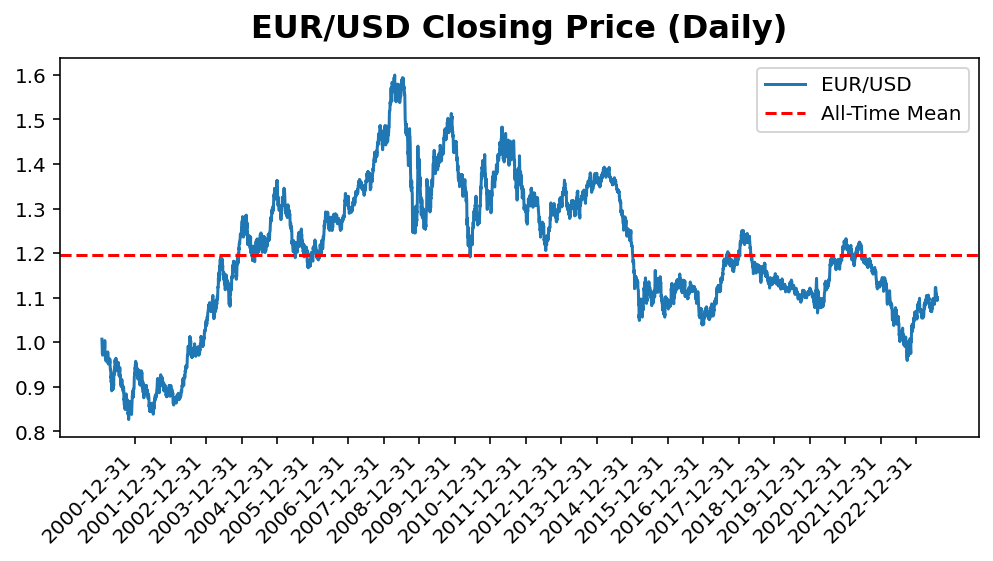

In [44]:
plt.figure(figsize=(7,4))
plt.plot(data.index, data['EUR/USD'], label='EUR/USD')
plt.axhline(y=data['EUR/USD'].mean(), color='red', linestyle='--', label='All-Time Mean')
plt.title('EUR/USD Closing Price (Daily)')
plt.legend()

# Set xticks to appear every 1 year
plt.xticks(pd.date_range(start=data.index[0], end=data.index[-1], freq='1Y'), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [45]:
data['Timestep'] = np.arange(len(data.index))
data = data.reindex(columns=['Timestep','DATE', 'EUR/USD'])
data.head()

,Timestep,DATE,EUR/USD
DATE,,,
2000-01-24,0,NaN,1.0071
2000-01-25,1,NaN,1.0012
2000-01-26,2,NaN,1.0003
2000-01-27,3,NaN,0.9882
2000-01-28,4,NaN,0.9749


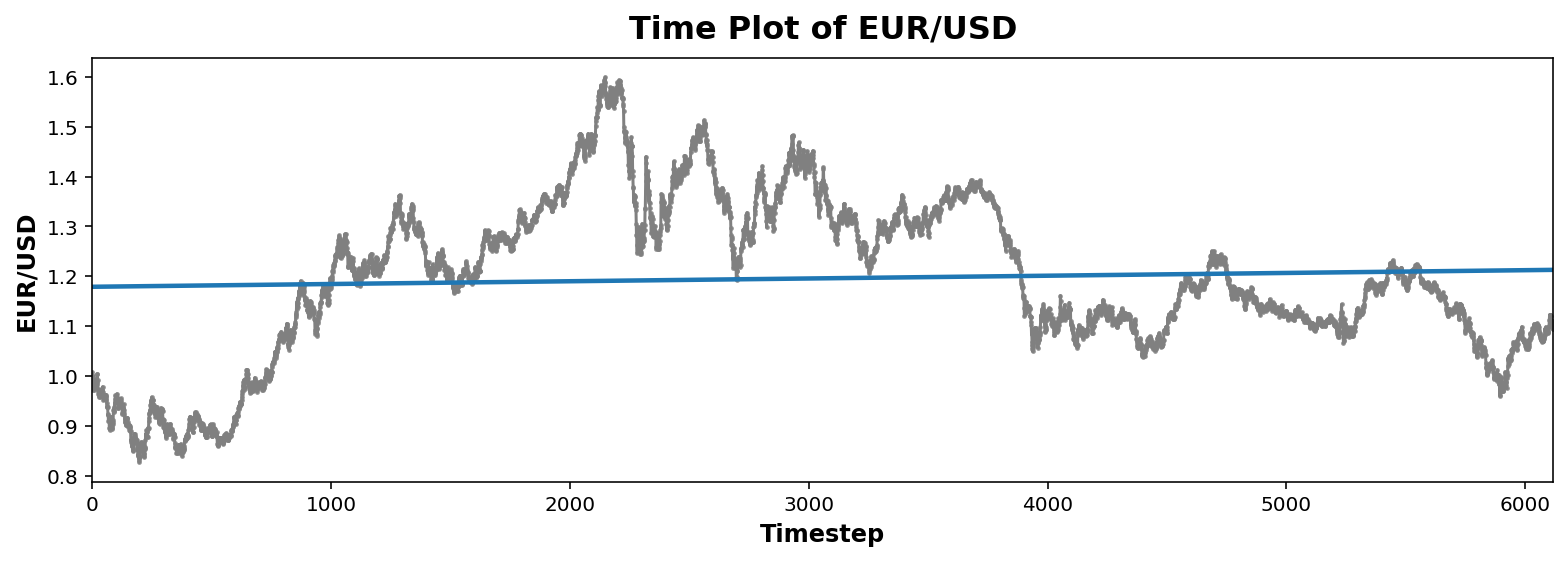

In [46]:
# Fit linear regression - not very useful as it is nearly a straight horizontal line
import seaborn as sns 

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Timestep', 'EUR/USD', data=data, color='0.5')
ax.set_title('Time Plot of EUR/USD');
# Fitted line - shows no time-dependent trend
ax = sns.regplot(x='Timestep', y='EUR/USD', data=data, ci=None, scatter_kws={'s': 2, 'color': '0.5'})

In [47]:
data['Lag_1'] = data['EUR/USD'].shift(1)

data.head()

,Timestep,DATE,EUR/USD,Lag_1
DATE,,,,
2000-01-24,0,NaN,1.0071,NaN
2000-01-25,1,NaN,1.0012,1.0071
2000-01-26,2,NaN,1.0003,1.0012
2000-01-27,3,NaN,0.9882,1.0003
2000-01-28,4,NaN,0.9749,0.9882


(0.8267, 1.0071)

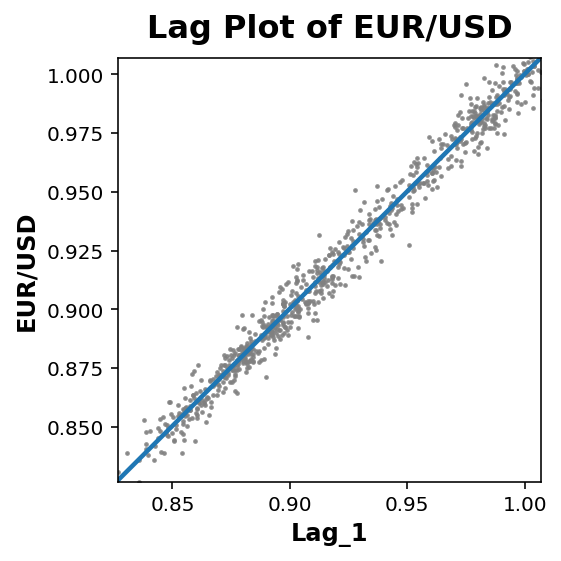

In [48]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='EUR/USD', data=data, ci=None, scatter_kws={'s': 2, 'color': '0.5'})
ax.set_aspect('equal')
ax.set_title('Lag Plot of EUR/USD');

# Limit the x-axis and y-axis
ax.set_xlim(data['Lag_1'].min(), data['Lag_1'][:25].max())  
ax.set_ylim(data['EUR/USD'].min(), data['EUR/USD'][:25].max()) 
# We see serial dependence

In [49]:
# Calculate the rolling moving average
moving_average = data['EUR/USD'].rolling(
    window=252,       # 252-day window
    center=True,      # puts the average at the center of the window
    min_periods=125,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)


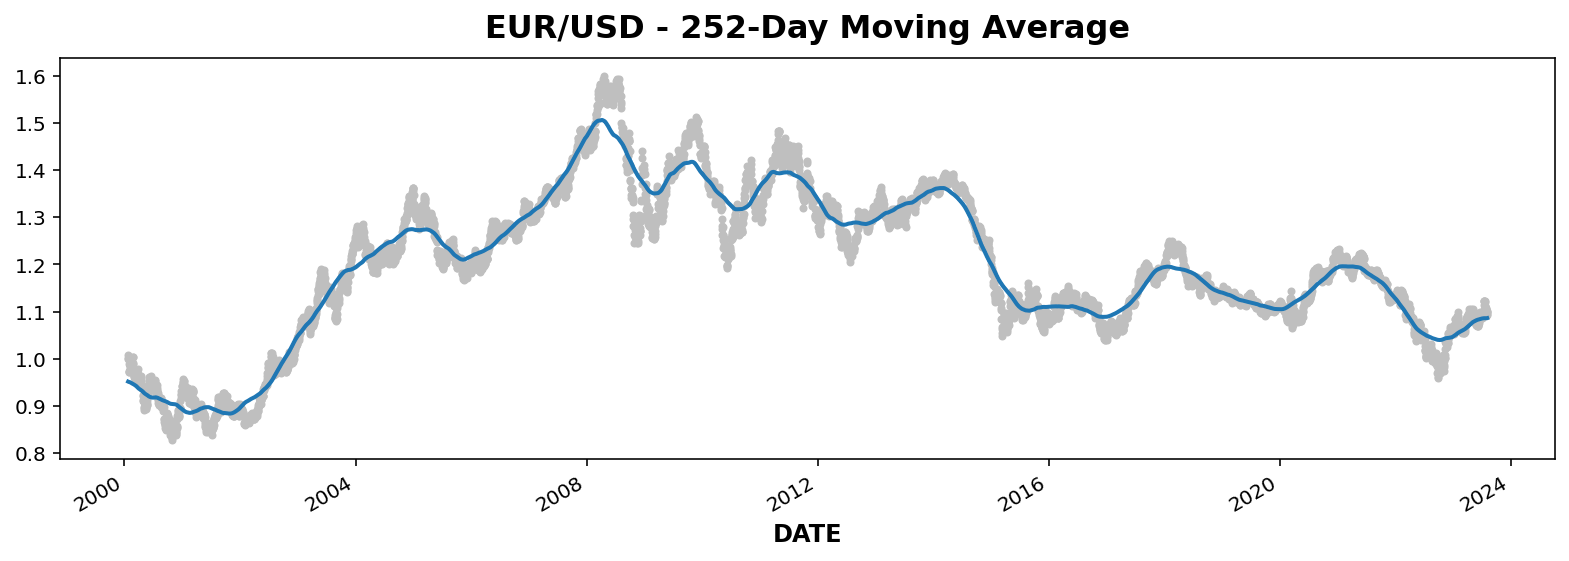

In [50]:
ax = data['EUR/USD'].plot(style=".", color="0.75")
moving_average.plot(
    ax=ax, linewidth=2, title="EUR/USD - 252-Day Moving Average", legend=False,
);

In [51]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

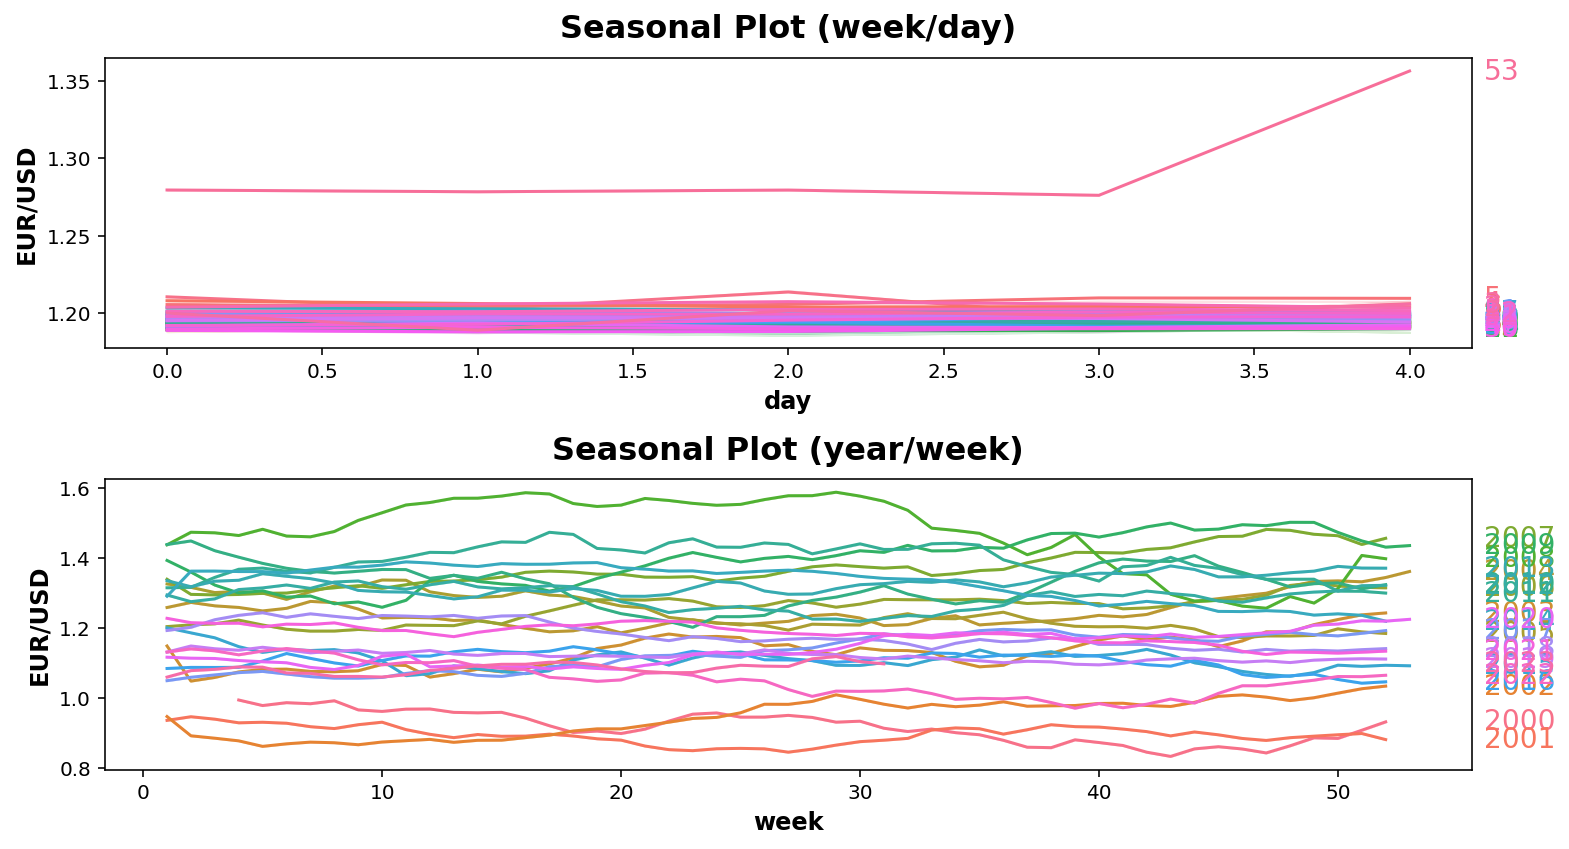

In [52]:
X = data.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="EUR/USD", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="EUR/USD", period="year", freq="week", ax=ax1);

In [53]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xlim(0, 52)
    ax.set_xticks([0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 12, 52])
    ax.set_xticklabels(
        [
            'Once every 20Y (1/20)',
            'Once every 10Y (1/10)',
            "Quinquennial (1/5)",
            "Biennial(1/2)",
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Weekly (52)"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<ipython-input-53-8ba91f383e39>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 52)


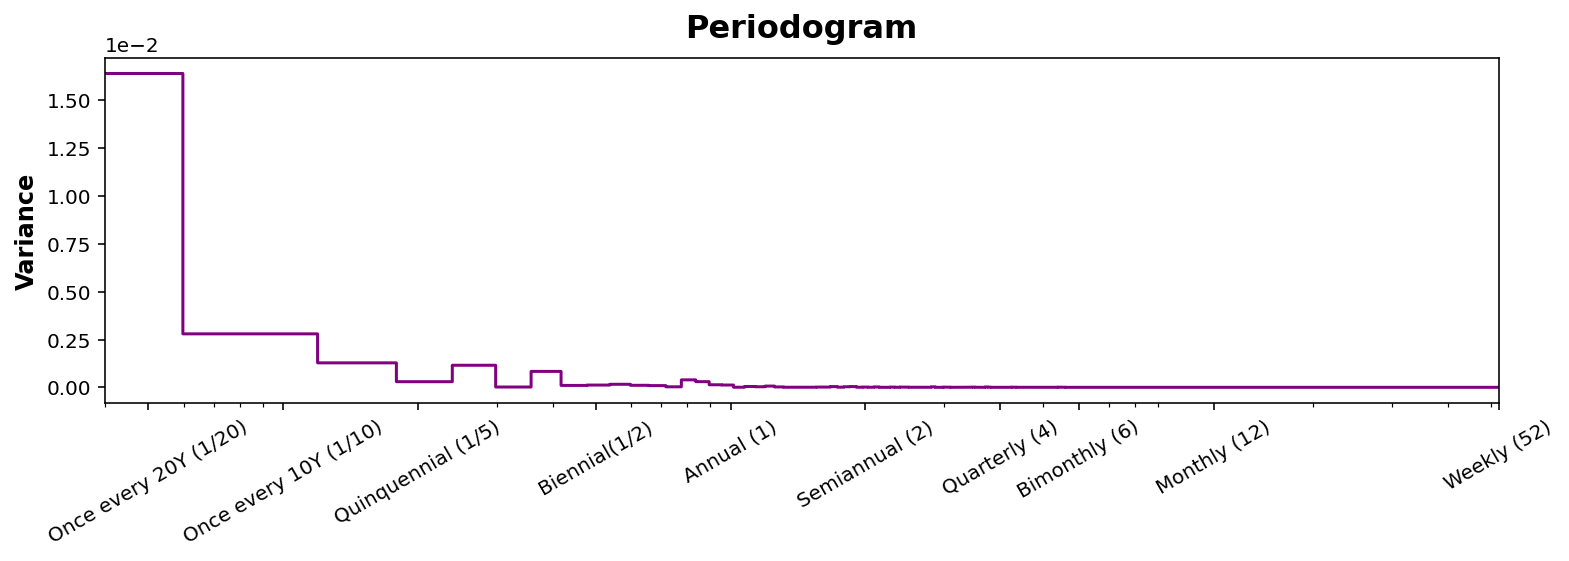

In [54]:
plot_periodogram(data['EUR/USD']);

In [ ]:
# Fourier Features